In [37]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from os import listdir
from os.path import isfile, join
import re
from imblearn.under_sampling import RandomUnderSampler
import umap

In [2]:
#Helper functions

#parse values as the initial index is included in every value
def parser(text):
  out = re.split(':', text)
  return float(out[1])

#bin the relevance into 0,1
def binRelevance(val):
  if val > 0:
    return 1
    
  else:
    return 0

In [3]:
####Run only to aggregate original source files, final files are provided##############
# #collect and aggregate the data
# dfs = []
# for i in listdir():
#     if re.search('txt',i):
#         dfs.append(pd.read_csv(i, delimiter=' ', header=None).drop(columns=[138]))
        
# agg = pd.concat(dfs)
# ##agg.shape
# ##agg.isna().sum()
# #drop nulls
# agg.dropna(inplace=True)
# #isolate dependent var
# relev_agg = agg.iloc[:,0].apply(int)
# #drop relevence measure and quid
# agg.drop(columns=[0,1], inplace=True)
# #parse values out of static text index within each column - Need to optimize this some how.  Very slow
# agg = agg.applymap(parser)

# #write to file
# agg.to_csv('agg_clean.csv', index=False)
# relev_agg.to_csv('dep_var_clean.csv', index=False)

### Read in Independent Variables

In [3]:
ind_df = pd.read_csv('agg_clean.csv')

In [4]:
ind_df.head(5)

,2,3,4,5,6,7,8,9,10,11,...,128,129,130,131,132,133,134,135,136,137
0,2.0,0.0,2.0,1.0,2.0,1.0,0.0,1.0,0.5,1.0,...,35.0,1.0,0.0,266.0,25070.0,28.0,7.0,0.0,0.0,0.0
1,2.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,...,17.0,93.0,0.0,153.0,12860.0,65.0,158.0,0.0,0.0,0.0
2,2.0,0.0,1.0,0.0,2.0,1.0,0.0,0.5,0.0,1.0,...,19.0,0.0,0.0,153.0,1131.0,112.0,141.0,0.0,0.0,0.0
3,2.0,0.0,2.0,1.0,2.0,1.0,0.0,1.0,0.5,1.0,...,50.0,81775.0,0.0,560.0,61224.0,1.0,14.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.5,0.0,0.0,0.0,0.5,...,24.0,0.0,0.0,57953.0,15600.0,15.0,12.0,0.0,0.0,0.0


In [6]:
ind_df.shape

(3600576, 136)

### Read in Dependent Variable

In [5]:
dep_df = pd.read_csv('dep_var_clean.csv')
dep_df['0'] = dep_df['0'].apply(int)

In [12]:
dep_df.head(3)

,0
0,2
1,1
2,3


In [13]:
dep_df.shape

(3600576, 1)

In [6]:
#Scale
scaler = StandardScaler()
ind_df.iloc[:] = scaler.fit_transform(ind_df.iloc[:])

### Understanding the Relevance Measure 
We can see below that there is a huge imbalance in the relevance measure.  We will need to explore options to account for that.  

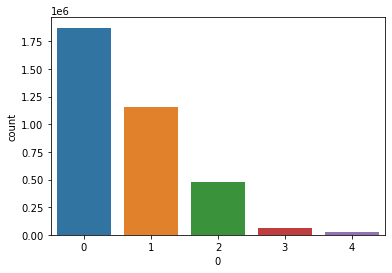

In [36]:
sns.countplot(x=dep_df['0']);

## Option 1 Binary Relevance Measure
If we determine that all relevance measures greater than 0 are 'relevant' and measure 0 is 'irrelevant' we may obtain a more desirable distribution. 

In [7]:
bin_relev = dep_df['0'].map(lambda x: binRelevance(x))

In [38]:
bin_relev.value_counts()

0    1872789
1    1727787
Name: 0, dtype: int64

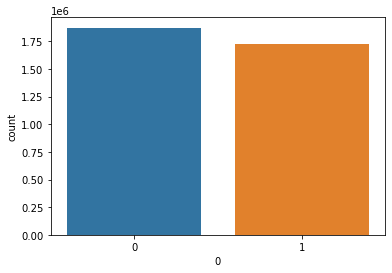

In [39]:
sns.countplot(x=bin_relev);

## Dimensionality Reduction

#### PCA

In [70]:
## Understanding how PCA will affect variation in data - takes a while, went with fully exhuastive approach
n_components = []
variance = []
for i in range(2,16):
    pca = PCA(n_components = i)
    pca.fit(ind_df)
    
    n_components.append(i)
    variance.append(sum(pca.explained_variance_ratio_))
    
    print(i)


2
3
4
5
6
7
8
9
10
11
12
13
14
15


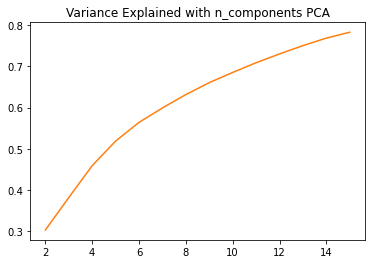

In [71]:
plt.plot(n_components, variance, color = 'tab:orange')
plt.title('Variance Explained with n_components PCA')
plt.show()

#### UMAP

In [28]:
#ind_df['tar'] = bin_relev
test_dims = ind_df.sample(n=50000, random_state=42)
#standard_embeding = umap.UMAP(random_state=42).fit_transform(ind_df)

In [29]:
standard_embeding = umap.UMAP(random_state=42).fit_transform(test_dims.iloc[:, :-1])

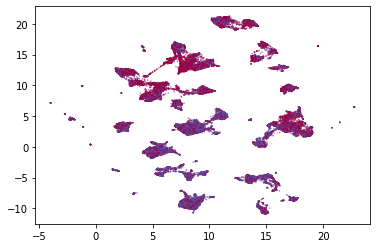

In [30]:
plt.scatter(standard_embeding[:, 0], standard_embeding[:, 1], c=test_dims['tar'], s=0.1, cmap='Spectral');

#### t-SNE

In [34]:
n_components = []
kl_divergence = []
for i in range(2,4):
    tnse = TSNE(n_components=3, learning_rate='auto', init='random').fit(test_dims.iloc[:, :-1])
    
    n_components.append(i)
    kl_divergence.append(tnse.kl_divergence_)
    
    print(i)





#X_tnse = TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(test_dims.iloc[:, :-1])

KeyboardInterrupt: 

In [ ]:
plt.plot(n_components, kl_divergence, color = 'tab:blue')
plt.title('Kullback-Leibler divergence after optimization with n_components')
plt.show()

## Option 2 Undersampling

In [55]:


X_train, X_test, y_train, y_test = train_test_split(ind_df, dep_df['0'], test_size=0.4, random_state=42)
y_train.value_counts()

0    1123997
1     695054
2     286883
3      38424
4      15987
Name: 0, dtype: int64

In [56]:
sampling_strat = {0:10000, 1:10000, 2:10000, 3:10000, 4:10000}
rus = RandomUnderSampler(sampling_strategy=sampling_strat)
X_bal, y_bal = rus.fit_resample(X_train, y_train)

In [57]:
y_bal.value_counts()

0    10000
1    10000
2    10000
3    10000
4    10000
Name: 0, dtype: int64

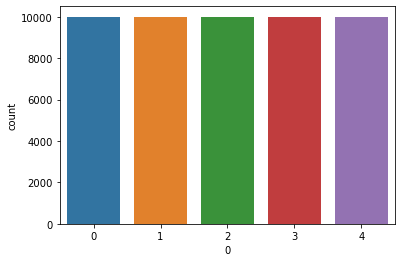

In [58]:
sns.countplot(x=y_bal);

In [42]:
pca = PCA(n_components=.8).fit_transform(ind_df)
X_train, X_test, y_train, y_test = train_test_split(pca, dep_df['0'],train_size=50000, test_size=1000, random_state=42)

#### Logistic Rregression

In [38]:
lr = LogisticRegression(random_state=42)

In [40]:
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [46]:
params = {'penalty': ['l2', 'none'], 'max_iter': [10000]}
lr_gs = GridSearchCV(lr, params, cv=5)
lr_gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'max_iter': [10000], 'penalty': ['l2', 'none']})

In [49]:
lr_gs.best_score_

0.5475399999999999

#### Random Forest

In [50]:
rf = RandomForestClassifier()

In [51]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
params = {'n_estimators': [10,50,100,200,500], 'criterion': ['gini', 'entropy'], 'max_depth':[None,2,5,10,20],'min_samples_split': [2,4,8,16], 'max_leaf_nodes': [None, 2,4,8,16,32,64]}
rf_gs = GridSearchCV(rf, params, cv=5,n_jobs=3)
rf_gs.fit(X_train, y_train)